# R-GCN Link Prediction

In this notebook, we’ll demonstrate how to use a **Relational Graph Convolutional Network (R-GCN)** for **link prediction**.
We will cover:
1. Loading and Preparing the Dataset
2. Building an R-GCN Model
3. Training and Optimization
4. Evaluation Metrics and Scoring (Precision, Recall, Cohen’s Kappa)
5. Visualization and Interpretability
6. Interactive Elements


## 1. Installation and Imports

Below we install and import the required libraries if necessary.

In [ ]:
# If you need to install PyTorch Geometric:
# !pip install torch torch-geometric

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import RGCNConv

# for evaluation:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

print("PyTorch version:", torch.__version__)
print("PyTorch Geometric imported.")

PyTorch version: 2.6.0
PyTorch Geometric imported.


## 2. Load and Prepare the Dataset

Here, we create or load a small synthetic relational graph. In practice, replace this with your real dataset. We also split edges into training, validation, and test sets for link prediction.

In [2]:
# Synthetic example with two relations (0 and 1)
edge_index = torch.tensor([
    [0, 1, 1, 2, 2, 3, 4, 5],  # Source nodes
    [1, 0, 2, 1, 3, 2, 1, 3]   # Target nodes
], dtype=torch.long)

# Relation types (one per edge)
edge_type = torch.tensor([0, 0, 1, 1, 0, 1, 0, 1], dtype=torch.long)

# Node features (dummy identity matrix for demonstration)
x = torch.eye(4, 4)

data = Data(
    x=x,
    edge_index=edge_index
)
data.edge_type = edge_type

print(data)

# Split edges into train/val/test
num_edges = data.edge_index.size(1)
train_size = int(num_edges * 0.6)
val_size = int(num_edges * 0.2)

indices = torch.randperm(num_edges)
train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

train_edge_index = data.edge_index[:, train_idx]
train_edge_type = data.edge_type[train_idx]
val_edge_index = data.edge_index[:, val_idx]
val_edge_type = data.edge_type[val_idx]
test_edge_index = data.edge_index[:, test_idx]
test_edge_type = data.edge_type[test_idx]

train_edge_index, train_edge_type, val_edge_index, val_edge_type, test_edge_index, test_edge_type

Data(x=[4, 4], edge_index=[2, 8], edge_type=[8])


(tensor([[1, 2, 5, 0],
         [2, 1, 3, 1]]),
 tensor([1, 1, 1, 0]),
 tensor([[1],
         [0]]),
 tensor([0]),
 tensor([[4, 2, 3],
         [1, 3, 2]]),
 tensor([0, 0, 1]))

## 3. Building the R-GCN Model

Below is a minimal R-GCN for link prediction:
- It uses learned node embeddings or provided features.
- Multiple RGCNConv layers.
- A simple concatenation-based scoring function for edges.

In [7]:
class RGCNLinkPredictor(nn.Module):
    def __init__(self, num_nodes, in_channels, out_channels, num_relations, num_layers=2):
        super().__init__()
        # Node embeddings (if nodes lack inherent features)
        self.node_embeddings = nn.Embedding(num_nodes, in_channels)

        # RGCN layers
        self.convs = nn.ModuleList()
        self.convs.append(
            RGCNConv(in_channels, out_channels, num_relations=num_relations)
        )
        for _ in range(num_layers - 1):
            self.convs.append(
                RGCNConv(out_channels, out_channels, num_relations=num_relations)
            )

        # Linear scoring layer
        self.scoring = nn.Linear(out_channels * 2, 1)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.node_embeddings.weight)
        for conv in self.convs:
            conv.reset_parameters()
        nn.init.xavier_uniform_(self.scoring.weight)
        if self.scoring.bias is not None:
            nn.init.zeros_(self.scoring.bias)

    def forward(self, x, edge_index, edge_type):
        # If x is None, we use the learned embeddings entirely.
        if x is None:
            out = self.node_embeddings.weight
        else:
            # Example: Summation of learned embeddings and provided features
            emb = self.node_embeddings.weight
            out = emb + x

        # Pass through R-GCN layers
        for conv in self.convs:
            out = conv(out, edge_index, edge_type)
            out = F.relu(out)

        return out

    def predict(self, node_embeddings, edge_index):
        # node_embeddings: [num_nodes, out_channels]
        source = node_embeddings[edge_index[0]]
        target = node_embeddings[edge_index[1]]
        # Concat node embeddings and feed to scoring
        score = self.scoring(torch.cat([source, target], dim=-1))
        return torch.sigmoid(score)


## 4. Training and Optimization

In link prediction, we often optimize by contrasting positive edges (from the graph) with negative edges (sampled randomly or via more advanced strategies). Here, we:

1. Generate negative samples.
2. Compute link likelihood for both positive and negative edges.
3. Use a binary cross-entropy style loss (via manual log-likelihoods) to distinguish between them.
4. Use an optimizer (e.g., Adam) to train the model.

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure num_nodes is inferred correctly from edge_index (in case it's synthetic)
num_nodes = int(data.edge_index.max().item()) + 1
num_relations = int(torch.max(data.edge_type)) + 1
in_channels = 8
out_channels = 8

# Adjust data.x to match [num_nodes, in_channels]
if data.x is None or data.x.size(0) != num_nodes or data.x.size(1) != in_channels:
    print(f"⚠️ Adjusting data.x from shape {None if data.x is None else data.x.shape} "
          f"to ({num_nodes}, {in_channels})")
    data.x = torch.eye(num_nodes, in_channels)

# Move data to device
data = data.to(device)

model = RGCNLinkPredictor(
    num_nodes=num_nodes,
    in_channels=in_channels,
    out_channels=out_channels,
    num_relations=num_relations,
    num_layers=2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Move edge splits to device
train_edge_index = train_edge_index.to(device)
train_edge_type = train_edge_type.to(device)
val_edge_index = val_edge_index.to(device)
val_edge_type = val_edge_type.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_type = test_edge_type.to(device)

def negative_sampling(num_neg_samples, num_nodes):
    i = torch.randint(0, num_nodes, (num_neg_samples,), device=device)
    j = torch.randint(0, num_nodes, (num_neg_samples,), device=device)
    return torch.stack([i, j], dim=0)

def train_one_epoch():
    model.train()
    optimizer.zero_grad()

    node_embeddings = model(data.x, train_edge_index, train_edge_type)

    pos_score = model.predict(node_embeddings, train_edge_index)
    neg_edge_index = negative_sampling(train_edge_index.size(1), data.num_nodes)
    neg_score = model.predict(node_embeddings, neg_edge_index)

    loss_pos = -torch.log(pos_score + 1e-15).mean()
    loss_neg = -torch.log(1 - neg_score + 1e-15).mean()
    loss = loss_pos + loss_neg

    loss.backward()
    optimizer.step()

    return loss.item()

# Train
for epoch in range(1, 1000):
    loss = train_one_epoch()
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Loss: {loss:.4f}")


Epoch 01 | Loss: 1.7361
Epoch 05 | Loss: 1.1211
Epoch 10 | Loss: 1.0837
Epoch 15 | Loss: 1.0111
Epoch 20 | Loss: 1.3463
Epoch 25 | Loss: 0.6435
Epoch 30 | Loss: 0.5447
Epoch 35 | Loss: 0.7939
Epoch 40 | Loss: 0.7500
Epoch 45 | Loss: 0.4419
Epoch 50 | Loss: 0.6426
Epoch 55 | Loss: 0.4476
Epoch 60 | Loss: 0.5798
Epoch 65 | Loss: 1.0390
Epoch 70 | Loss: 0.4400
Epoch 75 | Loss: 0.9126
Epoch 80 | Loss: 1.0593
Epoch 85 | Loss: 0.3970
Epoch 90 | Loss: 0.4705
Epoch 95 | Loss: 0.8063
Epoch 100 | Loss: 1.0001
Epoch 105 | Loss: 1.0408
Epoch 110 | Loss: 1.7395
Epoch 115 | Loss: 0.4477
Epoch 120 | Loss: 0.8242
Epoch 125 | Loss: 0.6657
Epoch 130 | Loss: 0.1590
Epoch 135 | Loss: 1.0935
Epoch 140 | Loss: 0.2721
Epoch 145 | Loss: 0.4674
Epoch 150 | Loss: 0.5148
Epoch 155 | Loss: 0.8595
Epoch 160 | Loss: 0.3678
Epoch 165 | Loss: 0.5239
Epoch 170 | Loss: 1.8098
Epoch 175 | Loss: 0.6302
Epoch 180 | Loss: 0.3766
Epoch 185 | Loss: 1.3949
Epoch 190 | Loss: 0.8024
Epoch 195 | Loss: 0.5310
Epoch 200 | Loss: 0.

## 5. Evaluation Metrics and Scoring

**Accuracy**, **F1**, and **Cohen’s Kappa** can provide valuable insights:
- **Accuracy**: The proportion of correctly classified edges (both positive and negative).
- **F1**: The mean of Precision and Recall. It balances both, especially when you want a single metric that captures the trade-off between precision and recall.
- **Cohen’s Kappa**: Offers insight beyond raw accuracy by considering chance agreement, which helps with imbalanced datasets.

Below is an example of how to compute these metrics. We do negative sampling again for the test or validation edges, get scores, and then threshold them to produce predictions. In practice, you might tune this threshold or rely on other decision rules.

In [13]:
def evaluate(edge_index, edge_type, threshold=0.5):
    model.eval()
    with torch.no_grad():
        # Obtain node embeddings
        node_embeddings = model(data.x, edge_index, edge_type)

        # Positive (real) edge scores
        pos_score = model.predict(node_embeddings, edge_index)

        # Negative edges (sample the same number as positive)
        neg_edge_index = negative_sampling(edge_index.size(1), data.num_nodes)
        neg_score = model.predict(node_embeddings, neg_edge_index)

    # Ground-truth labels: 1 for real edges, 0 for negatives
    y_true = torch.cat([
        torch.ones(pos_score.size(0), device=device),
        torch.zeros(neg_score.size(0), device=device)
    ], dim=0)

    # Combine predicted scores
    y_scores = torch.cat([pos_score, neg_score], dim=0)

    # Binarize predictions
    y_pred = (y_scores >= threshold).float()

    # Convert to NumPy
    y_true_np = y_true.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()

    # Compute metrics
    accuracy = accuracy_score(y_true_np, y_pred_np)
    f1 = f1_score(y_true_np, y_pred_np)
    kappa = cohen_kappa_score(y_true_np, y_pred_np)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'kappa': kappa
    }

In [14]:
metrics_val = evaluate(val_edge_index, val_edge_type, threshold=0.5)
print("Validation Metrics:", metrics_val)

metrics_test = evaluate(test_edge_index, test_edge_type, threshold=0.5)
print("Test Metrics:", metrics_test)

Validation Metrics: {'accuracy': 0.5, 'f1': 0.0, 'kappa': np.float64(0.0)}
Test Metrics: {'accuracy': 0.3333333333333333, 'f1': 0.0, 'kappa': np.float64(-0.33333333333333326)}


## 6. Visualization and Interpretability

Visualizing or interpreting an R-GCN can be done in various ways:
- **Node Embedding Visualization**: Project the learned embeddings (e.g., via PCA or t-SNE) into 2D.
- **Edge Score Heatmaps**: If the graph is small, you can illustrate predicted link probabilities.


In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np

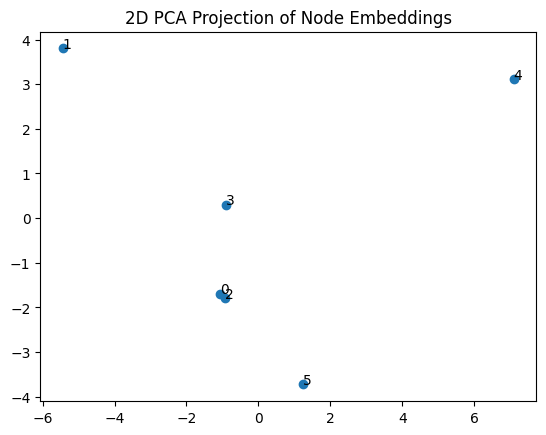

In [17]:
model.eval()
with torch.no_grad():
    # Get final embeddings using the entire graph
    embeddings = model(data.x, data.edge_index, data.edge_type).cpu()

# Reduce to 2D with PCA
pca = PCA(n_components=2)
embed_2d = pca.fit_transform(embeddings)

plt.figure()
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
for i in range(embed_2d.shape[0]):
    plt.annotate(str(i), (embed_2d[i, 0], embed_2d[i, 1]))
plt.title("2D PCA Projection of Node Embeddings")
plt.show()

/var/folders/fm/h1v7bpj91xq42mzzz55yn9fw0000gn/T/ipykernel_45058/2321278985.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  adj_matrix[src, dst] = scores[idx]


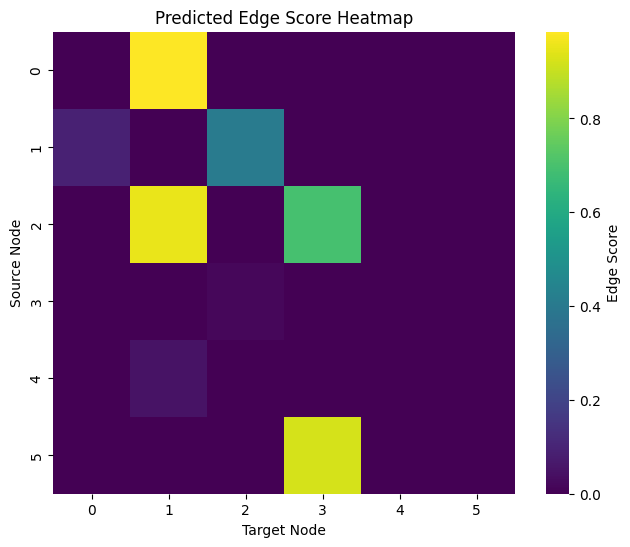

In [18]:
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index, data.edge_type)
    scores = model.predict(embeddings, data.edge_index).cpu().numpy()

# Convert edge_index to numpy for indexing
edge_index_np = data.edge_index.cpu().numpy()
num_nodes = data.num_nodes

# Create empty adjacency matrix
adj_matrix = np.zeros((num_nodes, num_nodes))

# Fill with scores
for idx in range(edge_index_np.shape[1]):
    src = edge_index_np[0, idx]
    dst = edge_index_np[1, idx]
    adj_matrix[src, dst] = scores[idx]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(adj_matrix, cmap='viridis', square=True, cbar_kws={'label': 'Edge Score'})
plt.title("Predicted Edge Score Heatmap")
plt.xlabel("Target Node")
plt.ylabel("Source Node")
plt.show()

## 10. Interactive Elements

For more advanced experimentation, you can use this widget to:
- Tune hyperparameters (e.g., learning rate, hidden size) via sliders.
- Dynamically update plots of training metrics in real time.

Below is a small example showing how you could integrate a widget for toggling the threshold during evaluation. *Make sure you have `ipywidgets` installed (e.g., `pip install ipywidgets`).*


In [20]:
from ipywidgets import interact, FloatSlider

@interact(threshold=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.5))
def interactive_evaluation(threshold):
    """Allows interactive threshold selection for link prediction."""
    metrics = evaluate(test_edge_index, test_edge_type, threshold=threshold)
    print(f"Threshold: {threshold:.2f}")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"F1:        {metrics['f1']:.4f}")
    print(f"Kappa:     {metrics['kappa']:.4f}")

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

Experiment to see how **precision**, **recall**, and **kappa** vary as the decision threshold for link existence changes.

## Conclusion

This tutorial demonstrates:
- Loading/preparing a relational graph.
- Building an R-GCN for link prediction in PyTorch Geometric.
- Training and optimization with negative sampling.
- Evaluating using multiple metrics.
- Simple visualization of node embeddings.
- Interactive threshold tuning with ipywidgets.
